# Basic classification using the SPEP model

This notebook explains how to use Markovflow to build and optimise a variational GP regression model (VGP) for a time series. Here, we perform binary classification with time as the input.

As with GPR, the observations do not have to be regularly spaced. However, they do need to be sequential. We denote the input/output tuples as $(x_i, y_i)_{1 \leq i \leq n}$, where $x_i$ is a scalar value and $y_i \in \{0, 1\}$.

Our probabilistic model for this data is:
$$
\begin{align}
f \sim \mathcal{GP}(0, k(., .)) \\
y_i \sim \mathcal{B}(\Phi(f(x_i)))
\end{align}
$$

where $\Phi$ is a function that maps $f(x_i)$ to $[0, 1]$, the probability that $y_i=1$. In practice, we choose $\Phi$ to be the standard normal cumulative distribution function (also known as the probit function) which maps to $[0, 1]$.

**NOTE:** If you have difficulty running this notebook, consider clearing the output and then restarting the kernel.

In [1]:
# Setup

import warnings

# Turn off warnings
warnings.simplefilter('ignore')


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from gpflow import default_float
from gpflow.ci_utils import ci_niter
from gpflow.likelihoods import Bernoulli


from markovflow.likelihoods import PEPScalarLikelihood
from markovflow.models.sparse_pep import SparsePowerExpectationPropagation
from markovflow.kernels import Matern52


np.random.seed(0)
FLOAT_TYPE = default_float()

# uncomment in notebook
# try:
#     from IPython import get_ipython
#     get_ipython().run_line_magic('matplotlib', 'inline')
# except AttributeError:
#     print('Magic function can only be used in IPython environment')
#     matplotlib.use('Agg')

plt.rcParams["figure.figsize"] = [15, 8]

2022-07-26 11:59:07.911127: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-07-26 11:59:07.911158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Step 1: Generate training data

First, let's generate some binary data $X = (x_1, \dots, x_n)$ and $Y = (y_1, \dots, y_n)^T$.

In [2]:
# Generate some observations
num_data = 300
num_inducing = 30
time_points = np.linspace(0 , 1, num_data)
F = np.cos(time_points * 20).reshape(-1, 1)
observations = (F + np.random.randn(*F.shape) > 0).astype(float)
data = (time_points, observations)
inducing_points = np.linspace(0 , 1, num_inducing)

In [3]:
matern_kernel = Matern52(lengthscale=.05, variance=1.0)
# Because we are multiplying them together, we need to train only one kernel variance parameter

kernel = matern_kernel

# We see Matern12 has only two dimensions (therefore there is less risk of overparameterising)
print(kernel.state_dim)

3


2022-07-26 11:59:09.308073: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-26 11:59:09.308237: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-07-26 11:59:09.308249: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-26 11:59:09.308266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az99-674): /proc/driver/nvidia/version does not exist
2022-07-26 11:59:09.308502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FM

## Step 3: Build and optimise a model

This is a classification problem with outputs between `[0,1]`, so we create a variational GP model using a Bernoulli likelihood.

2022-07-26 11:59:09.346260: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


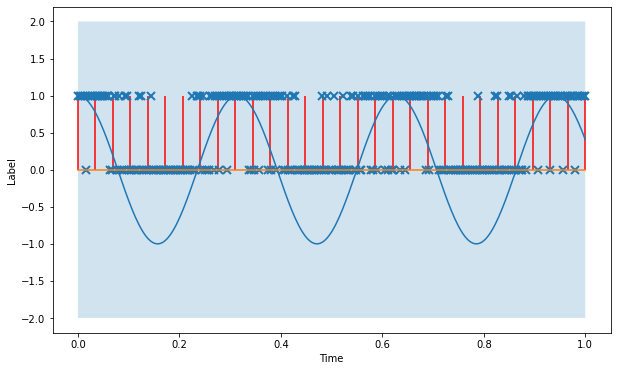

0 182.02568666405486


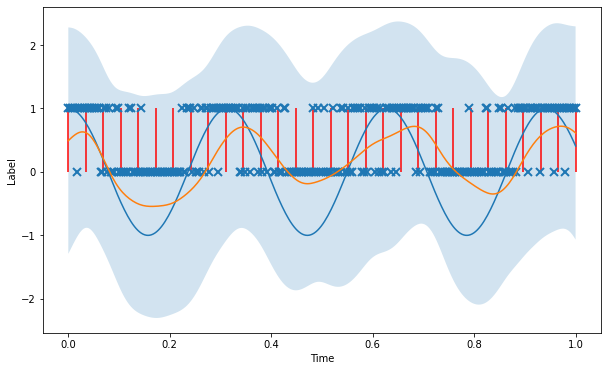

1 169.92616896254333


2 171.73937201822724


3 171.1480926195673


4 170.45070874575688


5 175.5654060760488


6 171.8506118526042


7 176.47102292773522


8 175.87276570448688


9 173.36000027878472


10 167.86710202157184


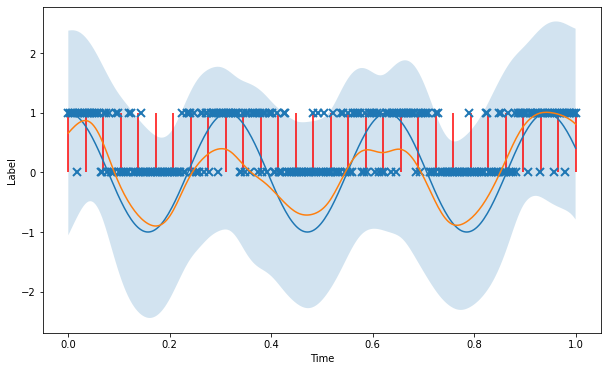

11 172.2556166717396


12 172.26635054190677


13 171.97235468634153


14 172.2670883918951


15 176.97651658438764


16 175.7925912394378


17 168.7003063920994


18 182.07351637623552


19 179.14580329675223


20 183.09375540501216


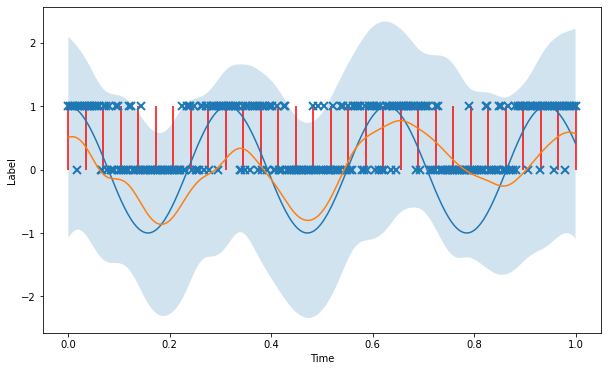

21 180.15113044468242


22 173.53359072451656


23 171.14091745320175


24 171.4372014746961


25 175.53849798500318


26 177.30231189877398


27 176.11200254962026


28 174.304913635227


29 176.03733903209522


30 172.75582519845366


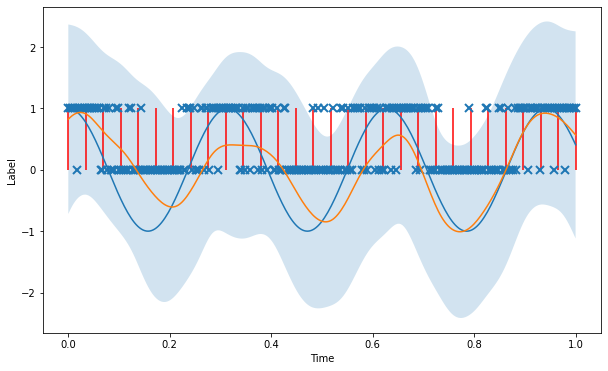

31 168.3536419625945


32 170.16300529226334


33 170.32318574659666


34 170.3266704537313


35 173.3996584158058


36 173.2740705114459


37 175.84163599555853


38 172.9409956459545


39 173.64343079388442


40 173.03339467394537


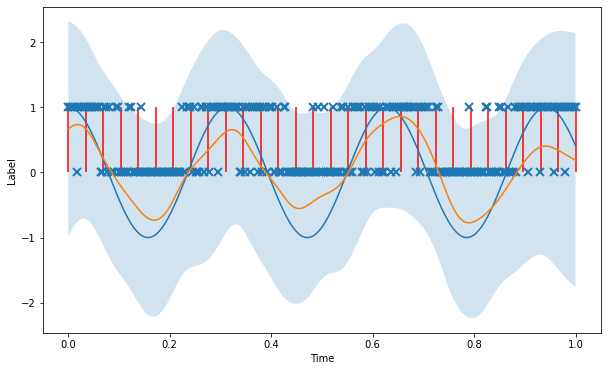

41 174.50258595815816


42 168.36442987619853


43 171.77845358157683


44 172.50561907352395


45 169.93112286113555


46 180.50806280974925


47 177.7855840332191


48 181.06772792327072


49 181.86193796185702


50 174.4285800131685


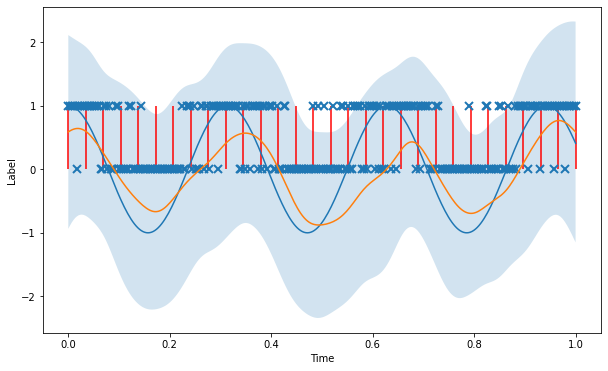

51 176.68277541503213


52 166.44935959552222


53 177.94014159560172


54 173.68564245831274


55 168.7771375685443


56 166.5815736780019


57 169.9234421209239


58 168.94972206296856


59 176.02507902442085


60 175.1929356489196


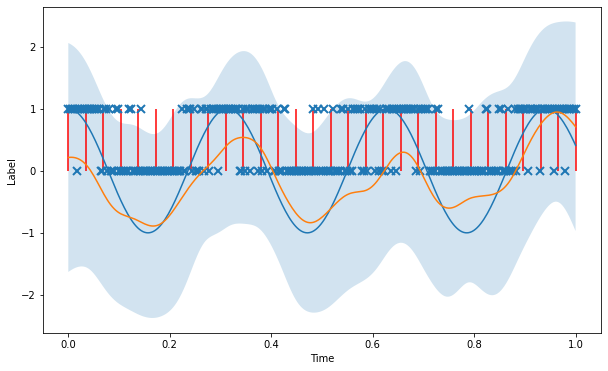

61 171.22794998872374


62 174.15856572313243


63 171.32061049638645


64 167.9761719494485


65 168.8092751988685


66 170.47650960671265


67 168.73364102140818


68 172.62122026871108


69 181.61895010380078


70 183.74649518079255


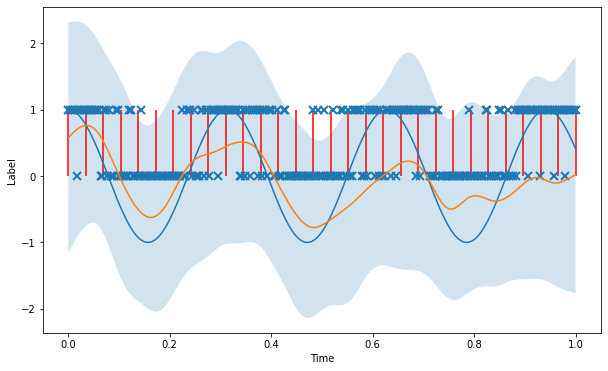

71 178.94052671519037


72 176.13467242952584


73 174.09838925780375


74 173.31651328398019


75 174.90036409139637


76 176.4349402528642


77 170.34145027458186


78 168.6307801002915


79 171.26766332078842


80 171.1660826878886


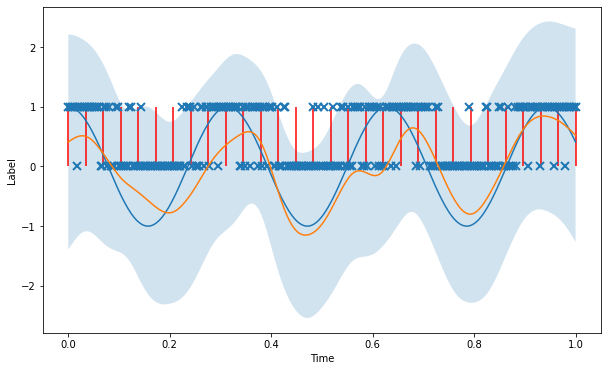

81 177.71536075281378


82 173.9606272575112


83 169.1097204916711


84 169.64272977607777


85 166.6026613719778


86 177.85866292746493


87 169.7852491164457


88 172.4798111694425


89 177.45144205994887


90 175.28484522691045


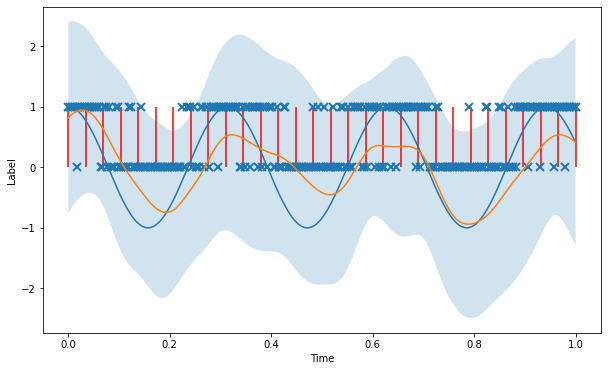

91 178.68715951655602


92 173.7123025904345


93 169.56742000358017


94 170.75276499952523


95 168.8893570810031


96 171.64714985316473


97 167.9149658659688


98 167.90882264122843


99 180.83077719427436


100 178.98330413223118


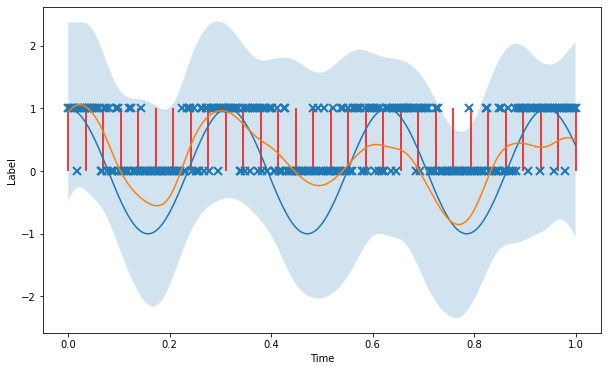

101 184.37300553847055


102 174.58503575836426


103 174.76066345626208


104 176.9794534873253


105 170.4644067583517


106 173.66032486410703


107 168.4166926031312


108 171.85503418409263


109 179.48086855136364


110 175.5246233371536


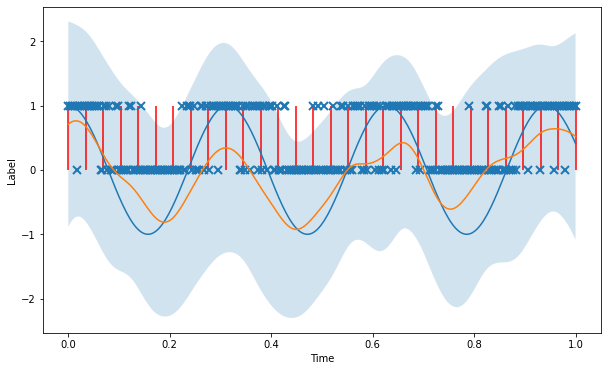

111 170.04659381323148


112 175.3747454468142


113 169.322368202617


114 175.20350885393447


115 174.88017637272665


116 177.89221438982037


117 179.88217081085992


118 169.3708811841934


119 173.86845576739276


120 170.09507066485338


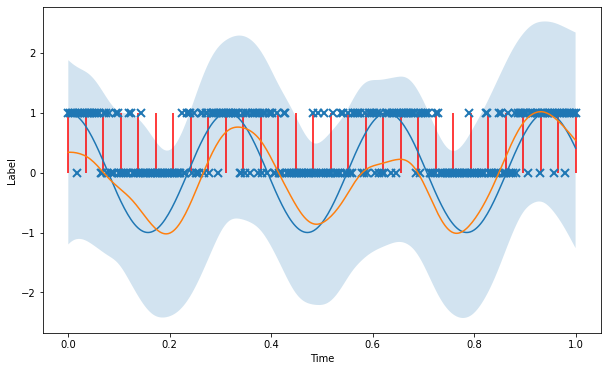

121 171.22968119093548


122 173.83604922158136


123 182.43935809064118


124 171.10765750648864


125 175.19452140876092


126 170.3401282942844


127 169.9813437236506


128 176.9963983775889


129 173.28725898058636


130 172.61069857140092


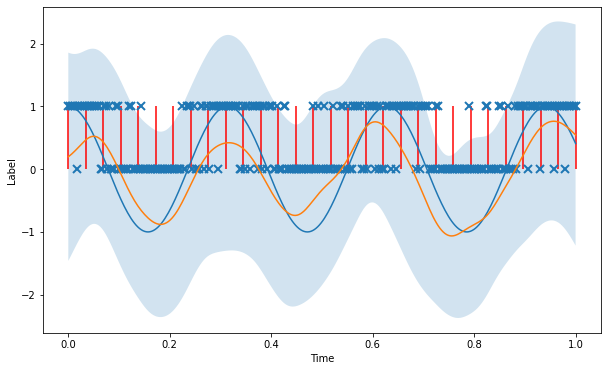

131 173.48622593647076


132 175.07932965581202


133 174.9144454955085


134 178.62698834964735


135 174.26921119073785


136 176.21677467125457


137 178.15690858355117


138 177.60065301853487


139 183.01458105211609


140 169.2717887178466


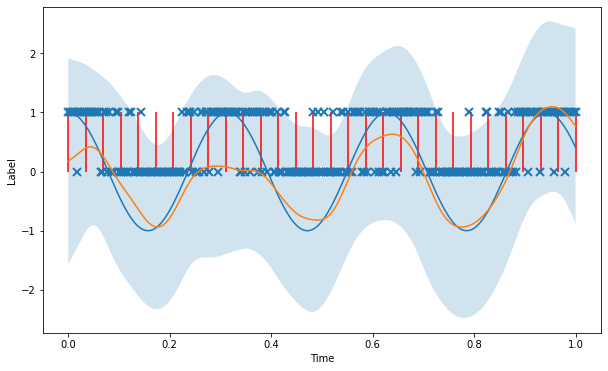

141 174.11221808040938


142 169.36455980013983


143 173.41600708390217


144 178.68228002754879


145 171.02420414420706


146 166.45657095050476


147 166.81557561604367


148 166.39133448047005


149 169.5820237875534


150 173.51778100934797


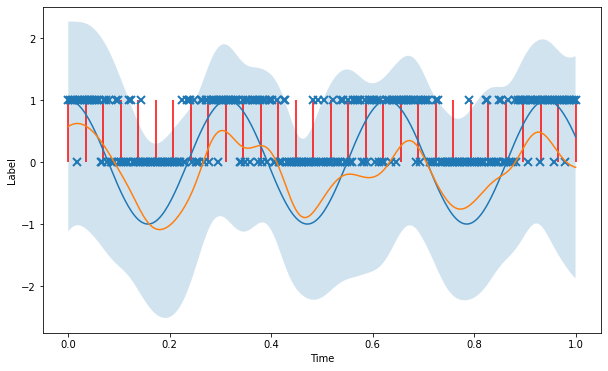

151 179.08425091547377


152 174.91403922182656


153 175.0342760818487


154 176.44560317038793


155 176.34207369010025


156 174.37025932040692


157 177.33635206135796


158 176.36156328619583


159 177.76939063623698


160 173.5745460394337


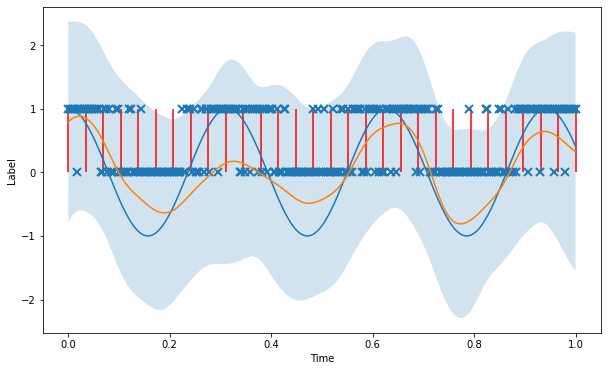

161 182.52526416724865


162 177.3506895124325


163 175.6289809279213


164 172.90889287184575


165 171.67184986781677


166 173.25772524319868


167 170.11976534491032


168 174.01611156910033


169 174.12870550632738


170 170.29259540417738


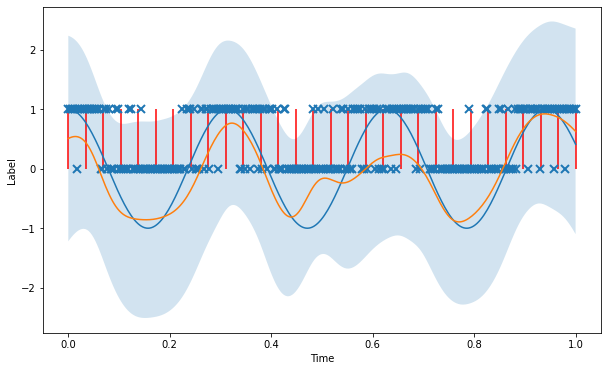

171 169.90945164462275


172 172.59893134411462


173 171.81281775469327


174 168.3045264608895


175 167.78172784223594


176 170.41738307210645


177 172.4592423020964


178 184.90657383845797


179 179.06823356272042


180 177.19253247973063


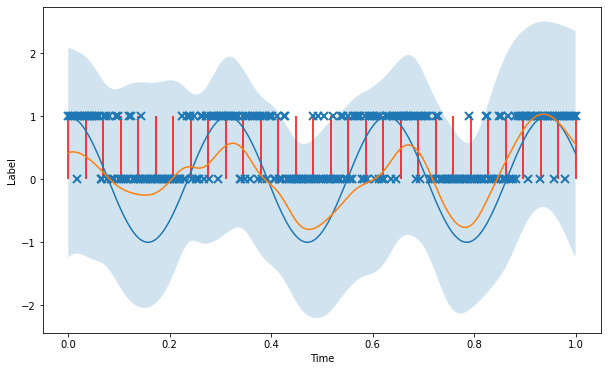

181 180.45867593723597


182 177.24503182322294


183 172.44622814190126


184 177.84389500149416


185 170.68785743765065


186 172.02222174867316


187 177.56204535198543


188 174.97469484374994


189 167.93951362835642


190 176.52012935373926


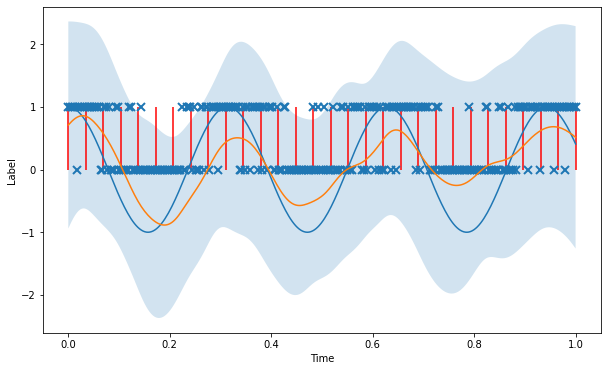

191 176.94929387985317


192 171.51449010151597


193 173.25893923660888


194 179.86571616577285


195 174.22719466945074


196 182.4855719663319


197 181.17619472904894


198 181.50350748353955


199 178.245302045327


200 173.73344481535378


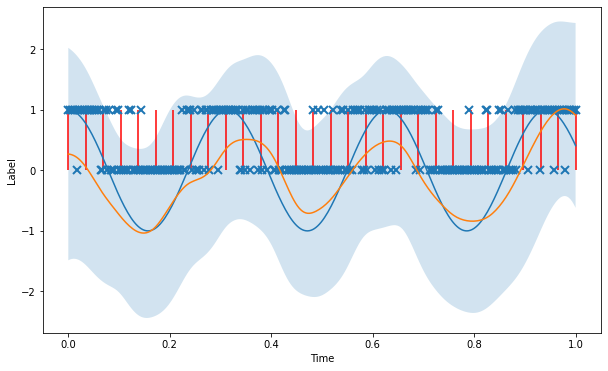

201 170.18917161662006


202 165.47359869835702


203 167.8472244131798


204 169.947003587605


205 169.36753041574207


206 177.0125529374034


207 171.4940202431987


208 174.45610936670124


209 172.54296615232386


210 174.95914694509122


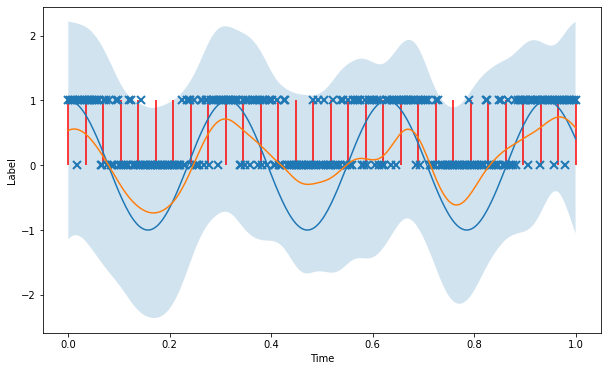

211 178.08319206449374


212 179.7431139427369


213 170.48837534239348


214 171.86761881262652


215 169.92342093735132


216 169.7793656210283


217 174.32268229606578


218 168.74239086643075


219 167.633732738753


220 167.009473635585


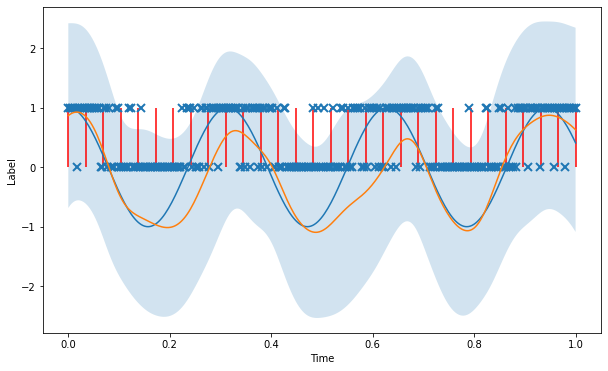

221 173.38373305714228


222 169.9224118482841


223 170.79665062619168


224 172.8389349976847


225 178.65610483130683


226 174.77096570732053


227 174.70240859832256


228 177.16418904879


229 173.03500277040064


230 172.728949865836


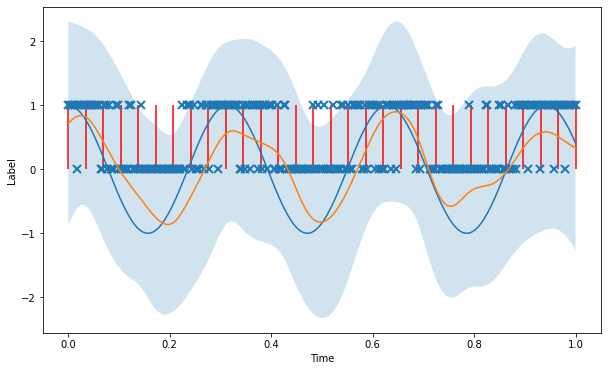

231 174.7064957561655


232 173.17932620145973


233 171.61551045826963


234 178.01959749676303


235 177.3829621355893


236 171.99286098267532


237 173.02609001752313


238 176.3455171062176


239 174.8240177754599


240 168.11045604325284


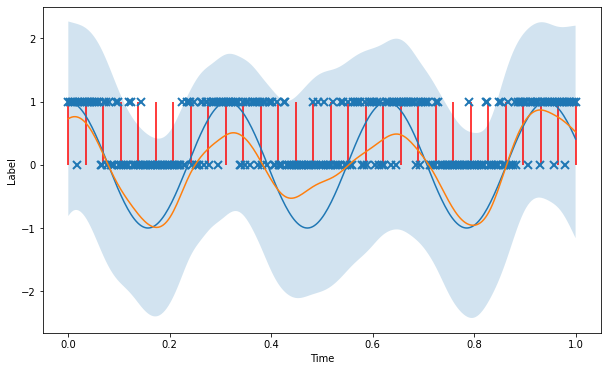

241 174.3652230418869


242 172.42983338324464


243 171.48176972318467


244 169.55247476946877


245 169.22925260993395


246 173.4026038674834


247 168.6359879580583


248 176.26902940775716


249 167.92256789398553


250 177.26142250601393


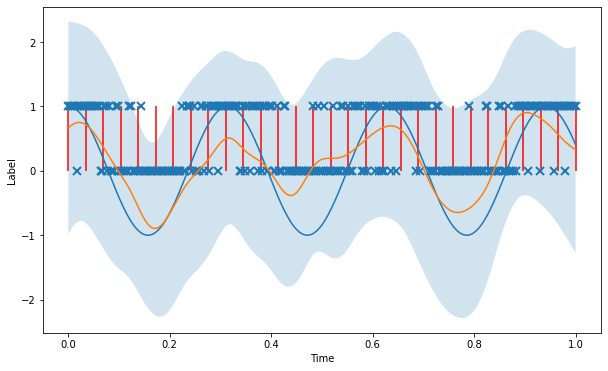

251 172.83749363686505


252 176.92901053204855


253 174.2867822808087


254 188.71768834441548


255 177.93405286810818


256 169.14704470810918


257 169.83301949955205


258 166.16412432270621


259 165.88296818411524


260 170.5164432751609


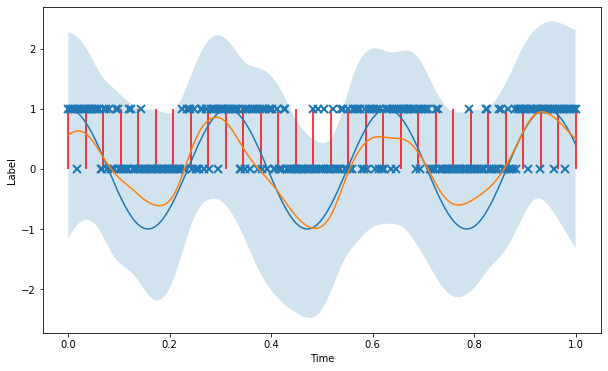

261 169.71018273847312


262 176.1174601680015


263 181.91582016239525


264 178.96945505287968


265 172.38065349000962


266 177.0717756385702


267 175.07143969690839


268 176.15990428691848


269 177.03541508581938


270 178.58715638862196


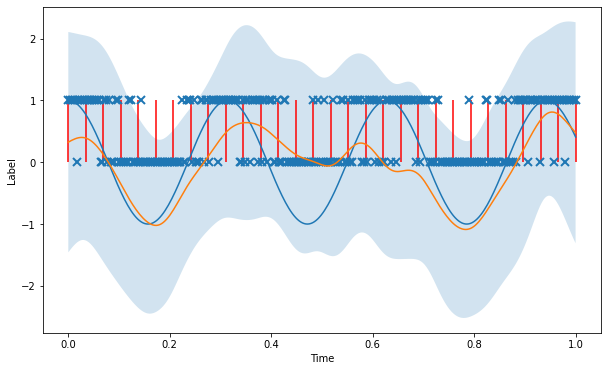

271 176.26620544674975


272 170.0707953393659


273 172.51666328581769


274 168.57085421371409


275 174.22621557564972


276 171.82108619099688


277 171.90270386663795


278 171.42782572231084


279 176.5740759756844


280 169.60064877686904


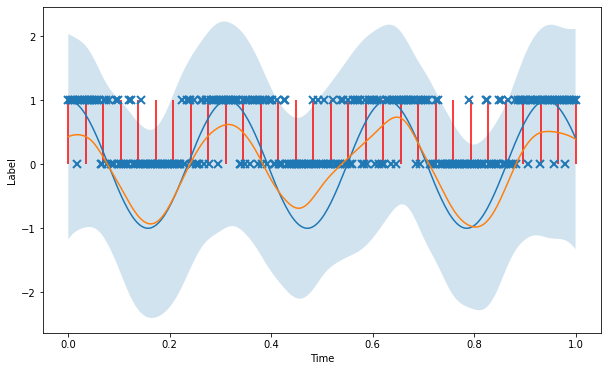

281 168.77504365351973


282 165.41889702605678


283 173.89908723243653


284 169.22376832859663


285 166.79150794872336


286 178.9215040020908


287 186.63621953434202


288 173.51467535413832


289 171.57076780031701


290 170.5259480397033


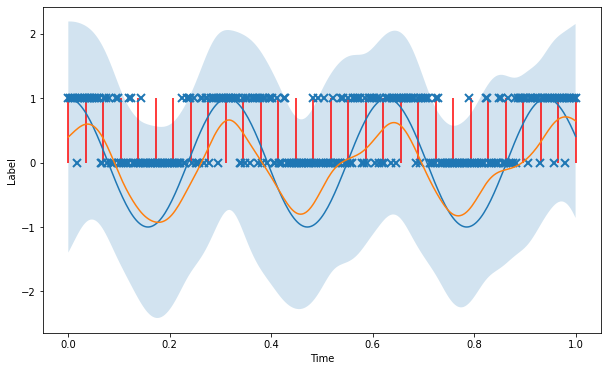

291 170.75046765005965


292 171.03615177853064


293 179.13089135191422


294 175.49267154400192


295 170.67456299028808


296 169.57749938972543


297 172.24204961909612


298 172.01473522784838


299 173.33284174933783


300 170.59549817326595


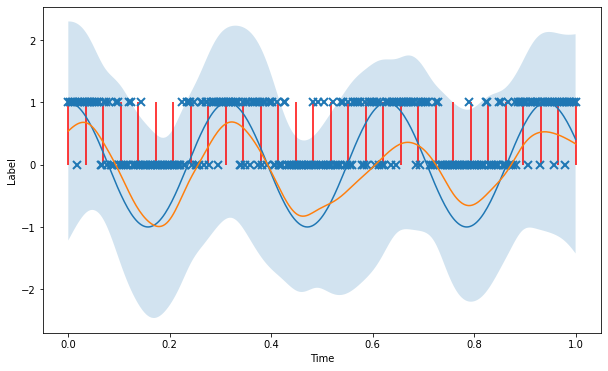

301 172.49605606296788


302 172.18443715470485


303 173.60988093239354


304 177.2290304238674


305 178.3069375937295


306 174.38409038990167


307 180.01217146379642


308 176.0198200372944


309 172.7442345379711


310 170.76760641438216


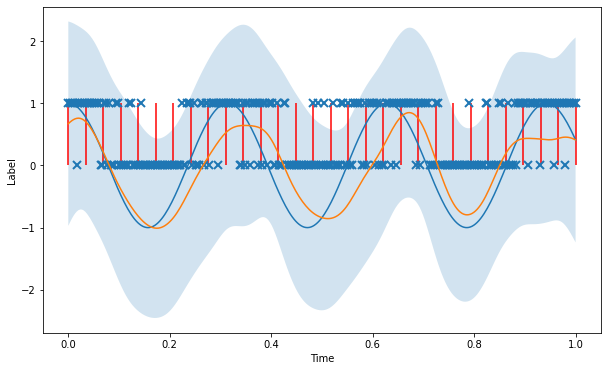

311 170.74761855454676


312 171.11033427297238


313 171.03450764653255


314 169.70171392948646


315 170.86621289417076


316 171.94612318317309


317 170.34254875747467


318 165.5374387037034


319 171.25305290096014


320 173.88398443111967


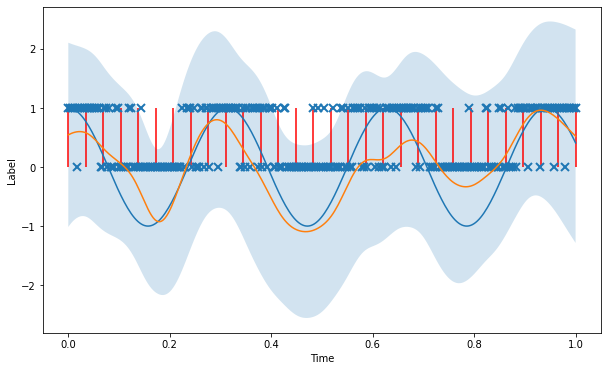

321 170.06961658300546


322 173.0634070630461


323 179.3026892268175


324 175.67449808065635


325 171.16618654199237


326 177.1877389904335


327 168.7131163327307


328 169.62634795543724


329 174.4825273367333


330 178.0993815587402


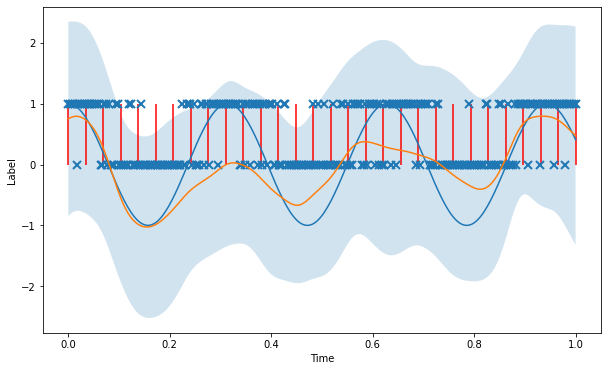

331 171.80714440362038


332 167.22959440790328


333 172.71398492832319


334 170.13229223170126


335 167.80379173823457


336 174.04682374404888


337 175.89406853752254


338 171.7109914841453


339 171.3632642250429


340 168.50341839401258


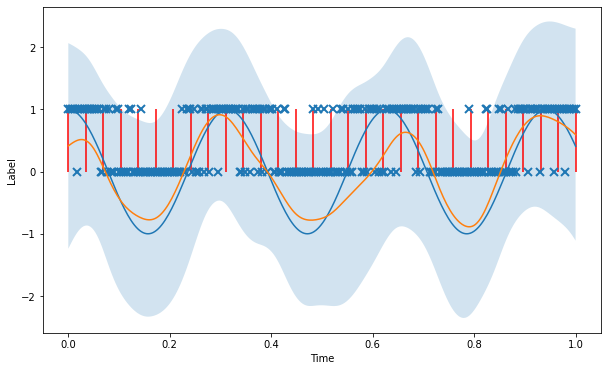

341 168.677641380557


342 174.31628666174478


343 168.99076430027318


344 168.93486358499632


345 179.28487468295535


346 170.23963675169338


347 167.66663846875832


348 172.87443772350025


349 168.5242138514332


350 166.24312697204704


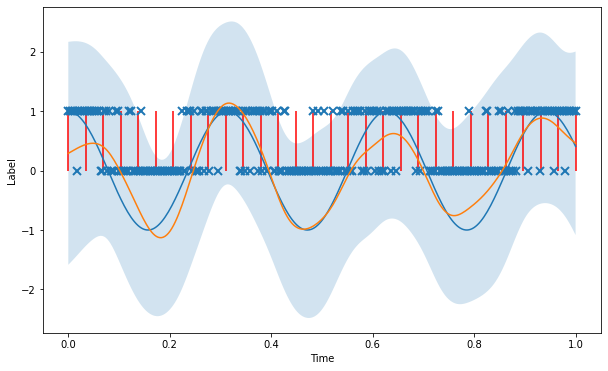

351 168.40670109730695


352 170.87130416583798


353 167.12399539140733


354 177.81481017170282


355 177.47093910723206


356 172.10418713367352


357 171.08985732352465


358 174.49617465650041


359 177.84803552882818


360 178.7416187644908


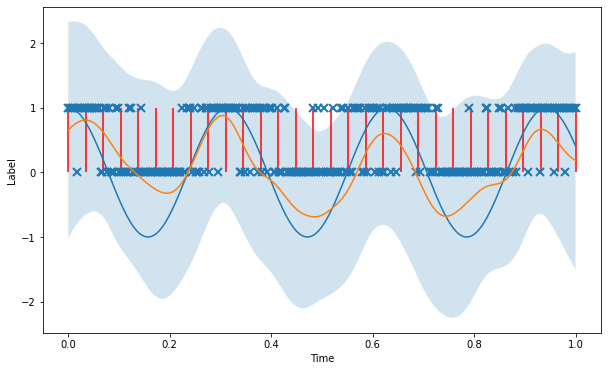

361 177.59802398714726


362 171.23732270828788


363 173.95149620505646


364 167.37818134706745


365 171.02088664381895


366 175.65967383873547


367 175.25212182788027


368 173.54638857237342


369 172.67540770935105


370 172.54885641973388


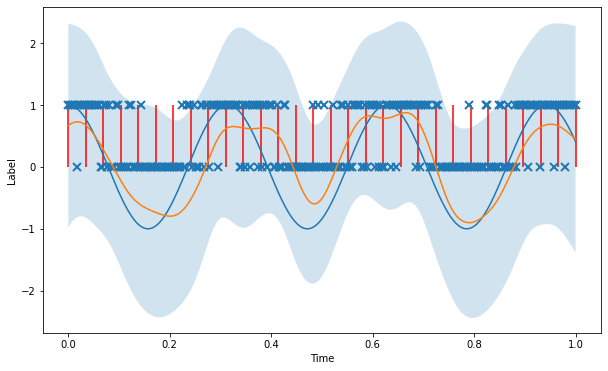

371 166.60272051248285


372 167.31467360068982


373 172.52827348446743


374 170.09573830275184


375 175.77751583941318


376 176.69140982724997


377 171.72108556101898


378 176.29255295526207


379 173.12020487285994


380 173.2304002532208


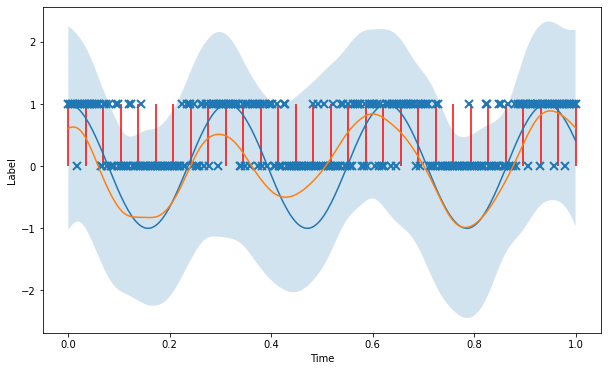

381 171.27412261036736


382 174.22187891350114


383 176.03224538931784


384 168.1467574023168


385 171.39155146529333


386 168.6998390480903


387 171.51300996438627


388 181.65496162240126


389 183.28683600830723


390 177.7723122742434


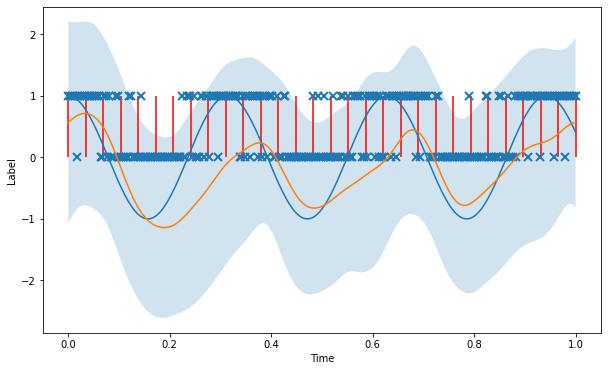

391 171.66955644225462


392 174.55008896829713


393 171.8401666131911


394 171.20368836405376


395 171.42903013615492


396 176.47341687503751


397 171.19296519099294


398 170.96064322390038


399 174.09030610573882


400 185.00535462903358


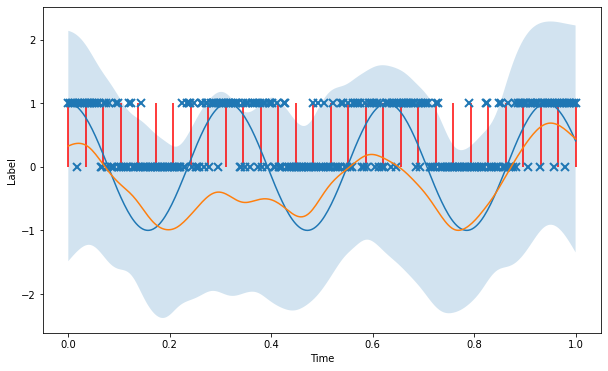

401 180.84134114257262


402 172.97720277153667


403 174.7743254522887


404 168.35515768340713


405 170.8282877302402


406 173.42242325676932


407 176.04491932947994


408 174.27883756967069


409 175.01023327368014


410 174.8393975505757


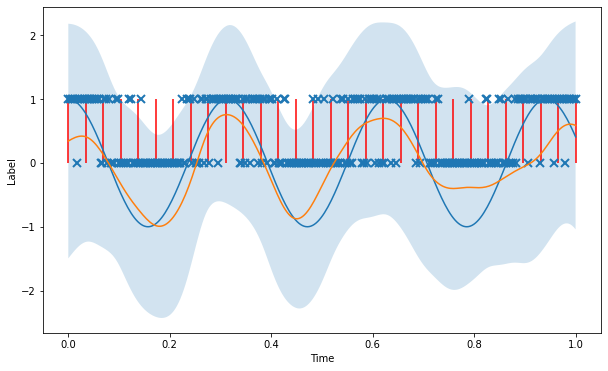

411 175.85242514777468


412 173.8493360647837


413 167.545495804007


414 177.7678580922213


415 175.65455909189245


416 169.32858257533007


417 173.68241807176116


418 171.5027950668767


419 167.93077174623699


420 182.6864657919906


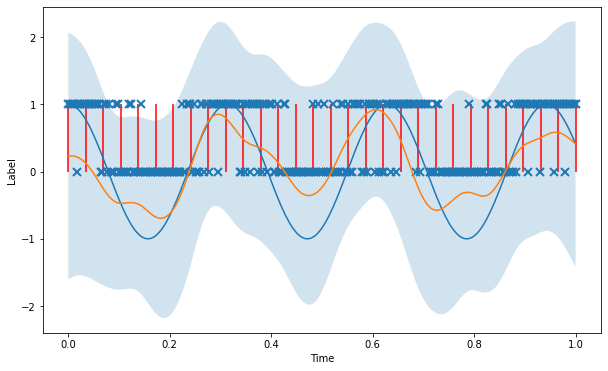

421 177.9819873709764


422 177.20733400293693


423 178.69678323904301


424 170.64923865411225


425 172.14339309064536


426 174.64911108006982


427 176.28086310038458


428 171.00986762945178


429 168.26525082142368


430 172.4000427592845


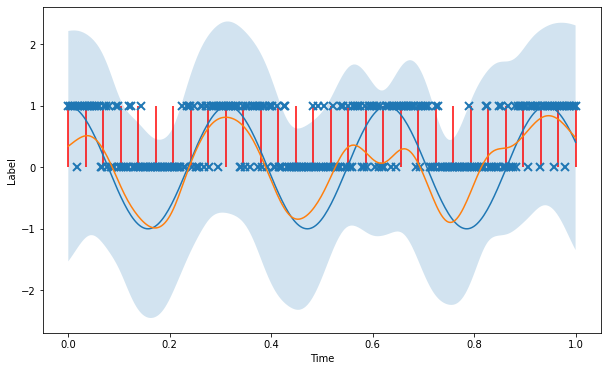

431 169.67383719297843


432 165.74379375740546


433 171.48656691117432


434 172.84003755210747


435 170.67658209950167


436 169.10052703294886


437 165.30179387065195


438 168.43214149568558


439 173.75928201649336


440 173.20080825408172


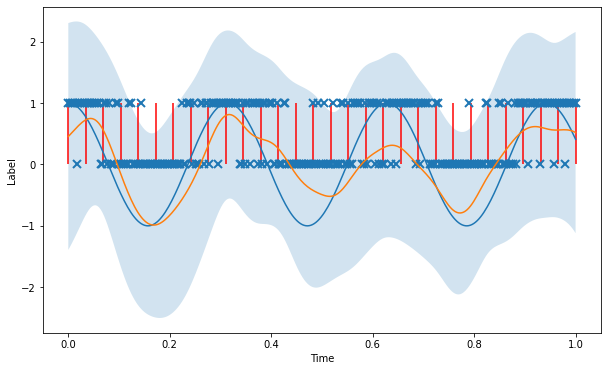

441 173.67897255373038


442 172.14150063881576


443 176.17395555288945


444 173.14235068025363


445 173.60997823451595


446 175.1053055982622


447 176.01465003963565


448 174.1796214997261


449 170.81350350681672


450 170.00005729371034


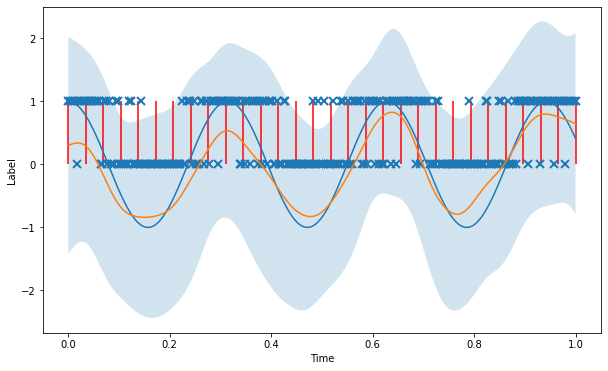

451 168.45182032291103


452 171.2761011916473


453 174.35216215011963


454 170.1994473665081


455 182.23458816825243


456 173.98395119705492


457 167.84019884643993


458 169.30028950820736


459 172.40685127384654


460 170.16318575001122


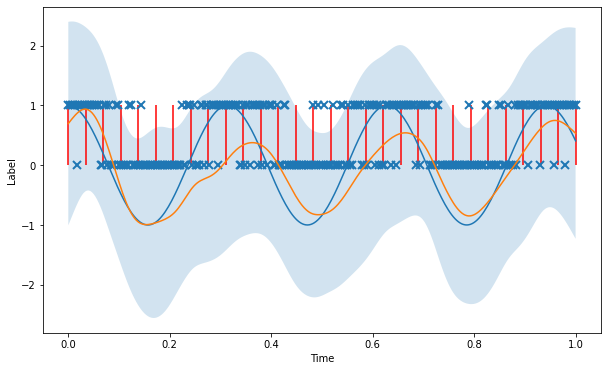

461 171.03088179271205


462 170.24180389802072


463 170.7638331793172


464 171.98960851222014


465 174.4623711466481


466 181.92573237973116


467 175.5228408479377


468 175.1734058863897


469 178.5116042698609


470 179.13047125820555


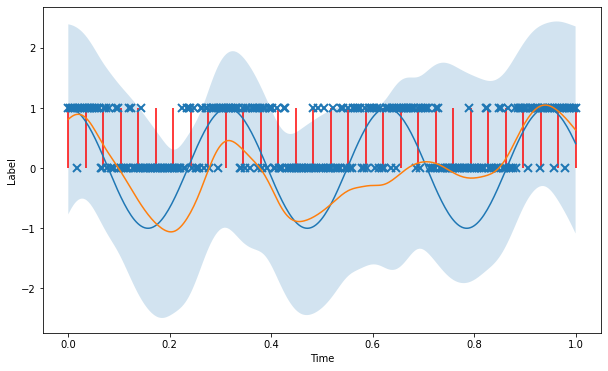

471 183.27536821561284


472 171.73186908432666


473 177.6287970323648


474 176.21601573138423


475 175.87580756328197


476 175.38072626508972


477 170.06563498131402


478 170.40997858599022


479 166.46069402745903


480 164.93686475728066


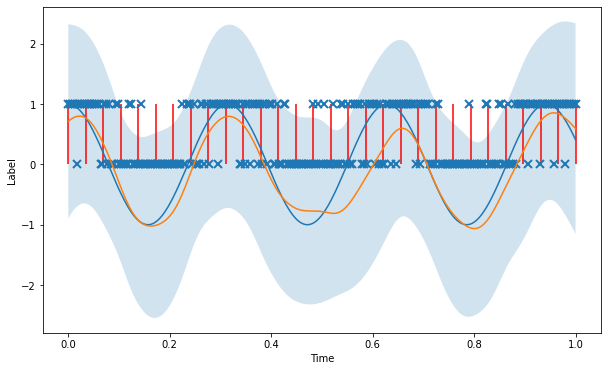

481 172.96791855201957


482 169.6766102854014


483 175.49434625546866


484 171.81574111903467


485 183.5929913117416


486 175.47756887515504


487 179.46509254688783


488 168.82302418459466


489 169.76294949915862


490 170.1869928831947


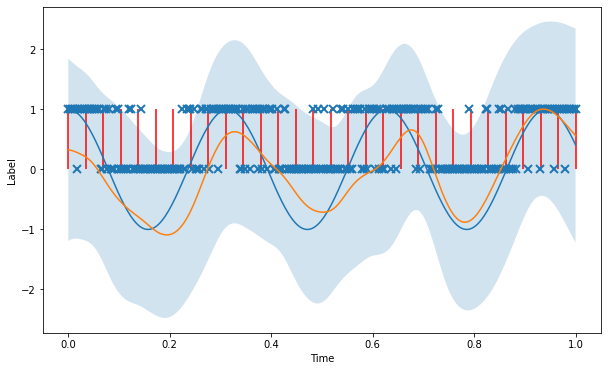

491 168.02352564493702


492 173.23997133342831


493 166.74919639874972


494 170.51644138968123


495 174.79837752648194


496 173.4303579751228


497 172.9503507723857


498 181.67641521978882


499 180.05240405686718


500 171.47531064507368


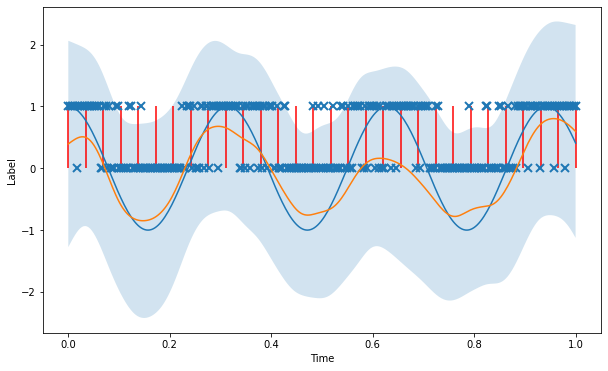

501 173.57856065164685


502 177.7288018897545


503 182.17440939779954


504 172.09213379132962


505 175.95290717790763


506 181.23654911940477


507 176.95988119084694


508 177.32225653311826


509 172.40219011034822


510 172.86685367114933


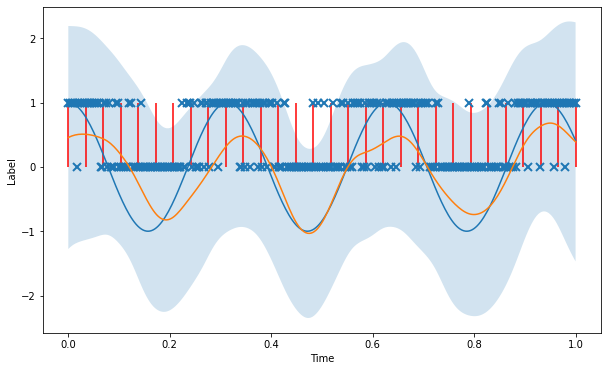

511 173.9148015824115


512 175.61191803100922


513 173.95474160240084


514 176.0686462236125


515 176.0414540211432


516 172.13623730369363


517 177.47293689300835


518 176.3501053737733


519 171.17340588671576


520 172.15067952519132


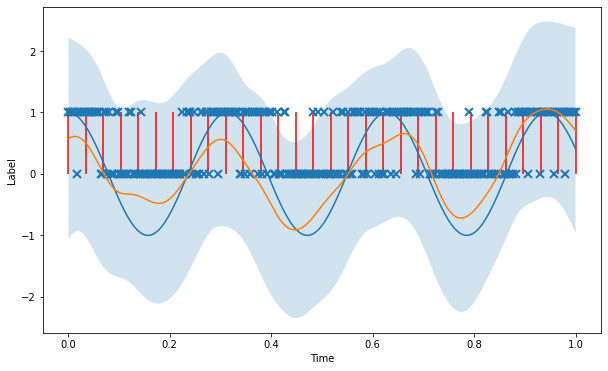

521 169.9312605727117


522 173.45003210607118


523 169.86808277132442


524 177.65948529759027


525 172.54237186770993


526 171.6752033416129


527 170.26056861740605


528 183.74292303362148


529 176.55273463774995


530 176.25889127592268


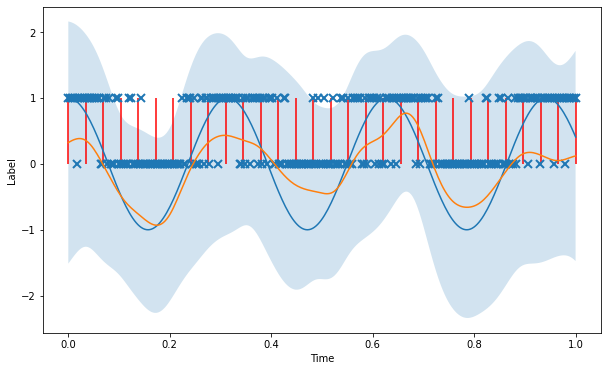

531 174.8651421740746


532 169.63035894460052


533 175.12020435459664


534 179.74939472267022


535 178.12578352743768


536 169.3638154829196


537 173.50625969123732


538 171.06994660150548


539 169.50557481815574


540 175.98377438452732


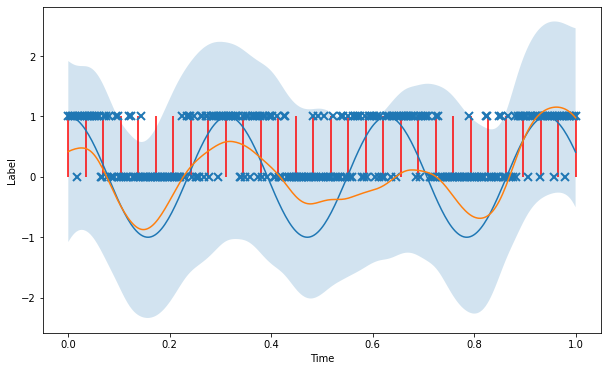

541 172.73383599937515


542 175.72923837916906


543 174.15083006638662


544 176.4182591252542


545 171.99860015641255


546 171.7626739117946


547 170.3125381371506


548 171.16988602914554


549 178.28975489086477


550 175.16343782766126


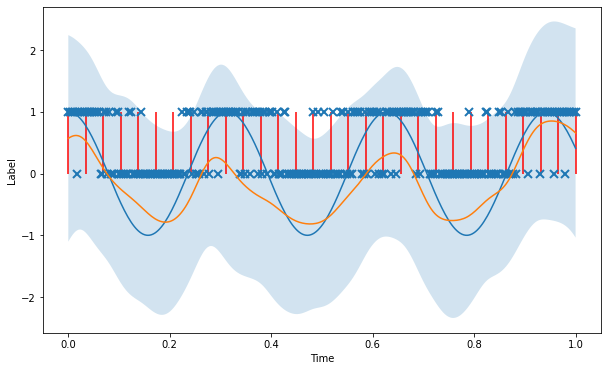

551 169.66137200866024


552 167.8313102824863


553 174.50184262111432


554 174.4708925192295


555 172.8526511581557


556 173.41832377377838


557 171.87921788861965


558 166.55307867618086


559 167.54860923377367


560 168.9403935752518


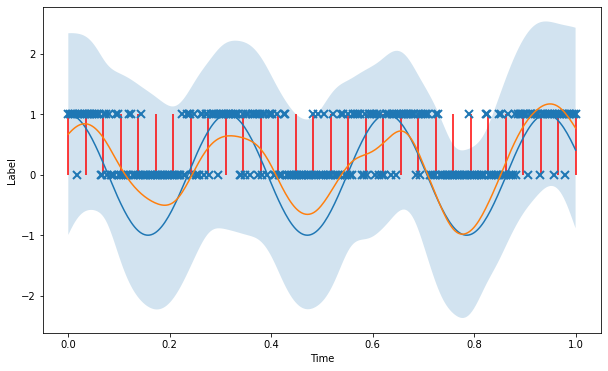

561 169.46070769710514


562 177.777320894252


563 176.2237638030318


564 173.11730503640757


565 169.40138991637605


566 168.4928904995126


567 173.00413874001882


568 178.69885341030755


569 172.56924857570823


570 174.33072582213362


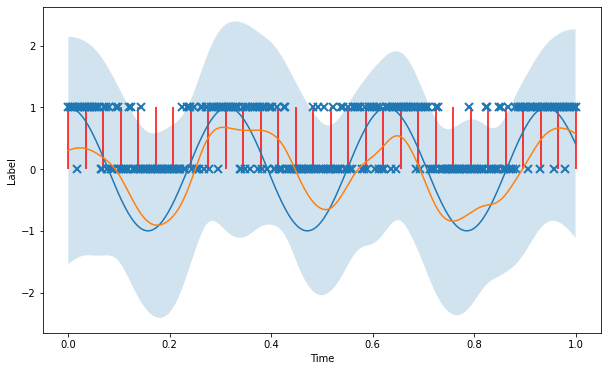

571 170.1102228789519


572 172.95282084896823


573 174.21372483967204


574 173.21637413486857


575 170.9513316028416


576 170.94086233019974


577 171.46048687177415


578 170.30815580838677


579 169.00924099212776


580 165.40038673304437


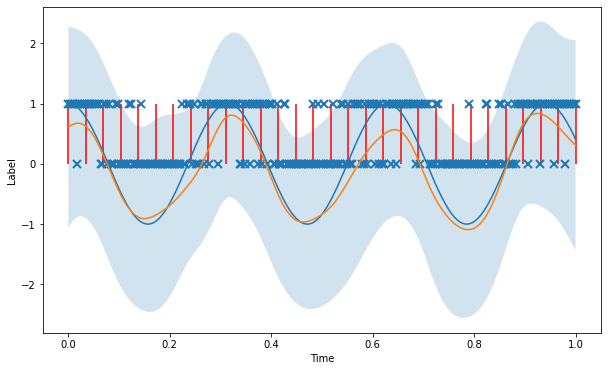

581 169.629988716642


582 175.23859996966667


583 175.5729012615298


584 169.72151115347302


585 172.45099542877452


586 171.29751747052248


587 179.20386116020822


588 177.60753960151376


589 169.76080906540977


590 172.31181963926593


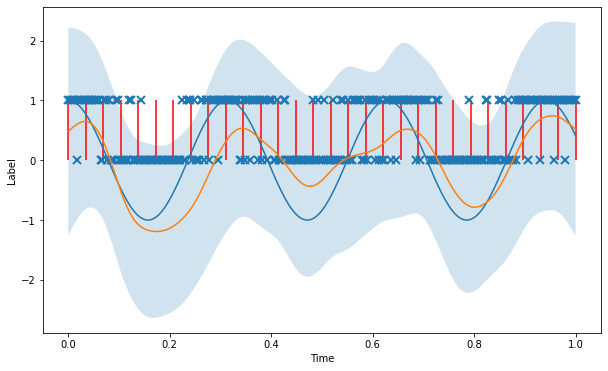

591 169.66657234725096


592 171.3074542786752


593 174.32566658652053


594 171.07645311079662


595 171.65771339778453


596 171.84762368506568


597 170.81819056850156


598 170.73980506946995


599 174.49940263899944


600 168.3315509422125


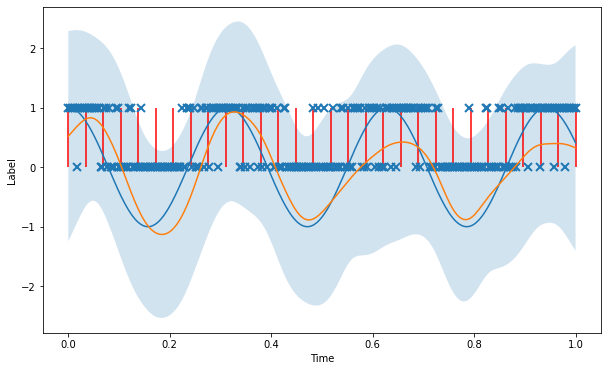

601 167.16327600185056


602 169.98910016753325


603 167.08537698696003


604 168.9562353195385


605 169.63745859711258


606 173.53647024896333


607 180.6932474287218


608 174.19720171686447


609 174.14276819536653


610 174.42447067301882


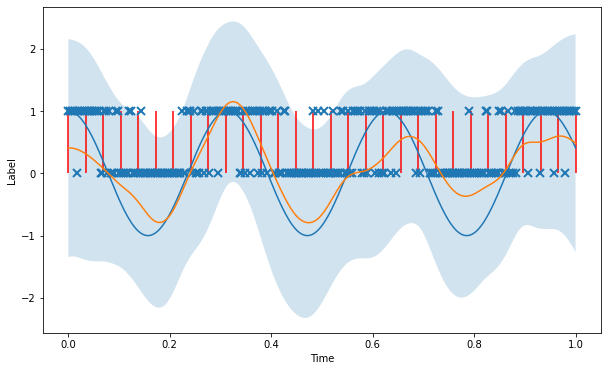

611 171.6096505959724


612 174.11165627543008


613 179.90055105633002


614 171.3067566399579


615 173.6535548087113


616 169.9569890249177


617 174.82493872244257


618 173.28220139096942


619 166.14281802702035


620 169.03033576639683


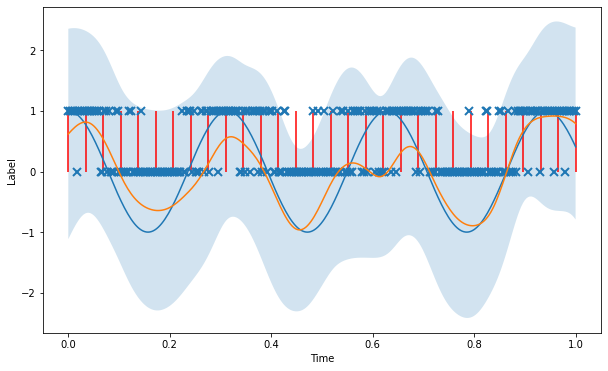

621 169.02373510523282


622 175.59846197858974


623 170.79490306733712


624 169.18384907676943


625 169.1079852355532


626 169.2202169345455


627 170.929142690462


628 174.8294364013005


629 176.6765885416523


630 173.3480448683605


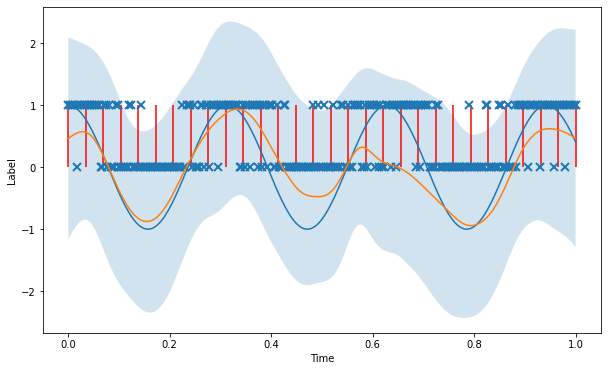

631 177.6361088691261


632 172.43945473239296


633 174.1864145711762


634 172.34654597565938


635 171.39472894483774


636 175.94646177993323


637 173.4995982335961


638 179.6610404552779


639 190.61971740166408


640 175.31564645859785


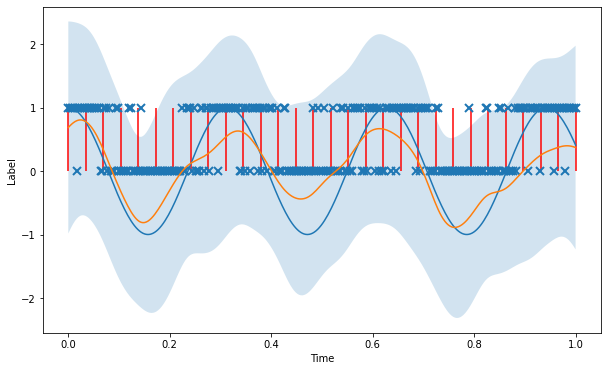

641 181.6104169144128


642 180.43498627115986


643 174.0468190741392


644 181.2073814573768


645 169.17159105477327


646 170.25961069565557


647 168.98191653612207


648 174.81802204407157


649 177.04421800386302


650 171.65148975953693


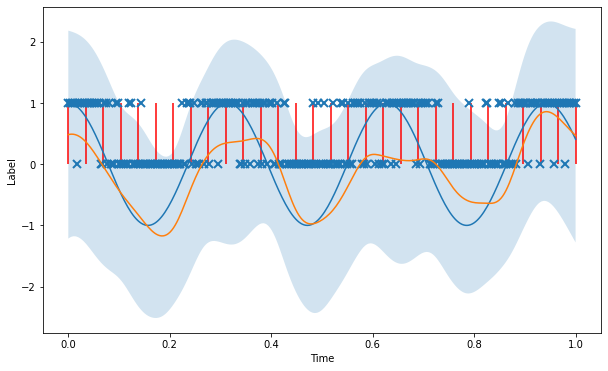

651 168.64023709596836


652 170.55834681759


653 170.13971076351564


654 170.89393860976207


655 171.1274563241162


656 167.1972814703838


657 179.3599693789219


658 173.94131006000293


659 174.9883458910268


660 176.10993937219112


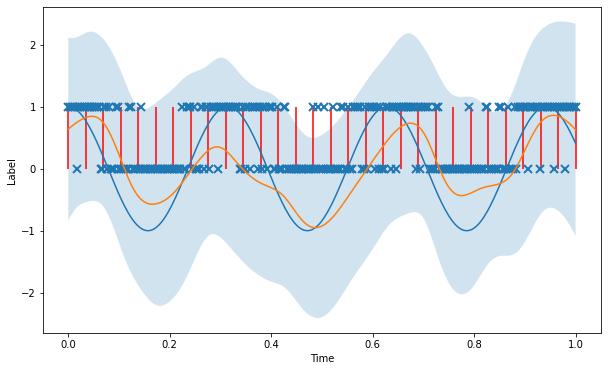

661 171.1354449713812


662 166.80849602833402


663 169.8967344637637


664 171.9659957925258


665 171.55998970409854


666 172.79350905703862


667 169.71295638821582


668 175.27803449160018


669 172.3611978072037


670 172.6086309532535


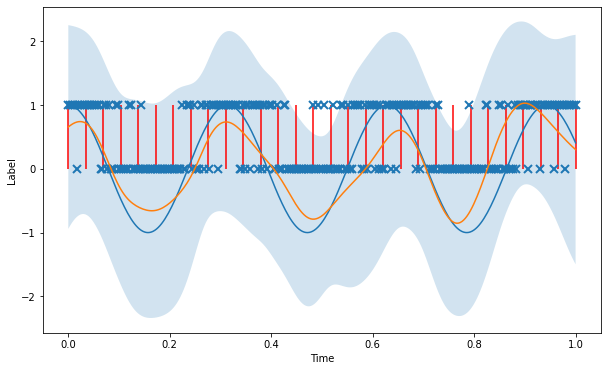

671 171.22687268216234


672 174.46193709015725


673 170.56410815343048


674 173.93265594075766


675 171.62509152280347


676 180.81068716090016


677 183.44916594296546


678 175.1308315957414


679 173.34022225810668


680 173.62833599195534


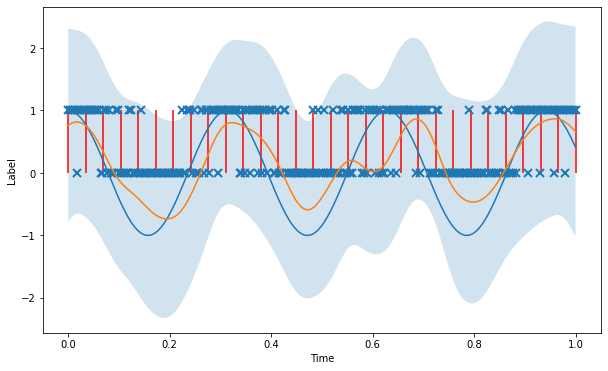

681 174.0272315313134


682 170.68877798748647


683 169.60772889674118


684 172.68215189069272


685 174.12257632155118


686 176.85824954200626


687 171.22755598004647


688 169.27096749219277


689 167.97455558828307


690 169.56948799316984


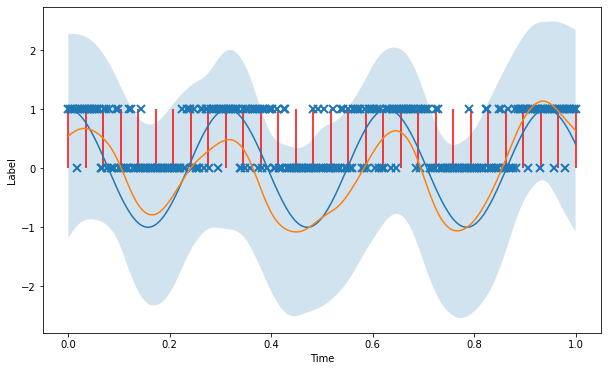

691 174.7940888562132


692 178.0747665989227


693 178.7426557022697


694 173.2109058860506


695 173.71402650364317


696 168.98410559596718


697 167.2380799846912


698 167.56153611310256


699 166.1880878927313


700 174.5742201877826


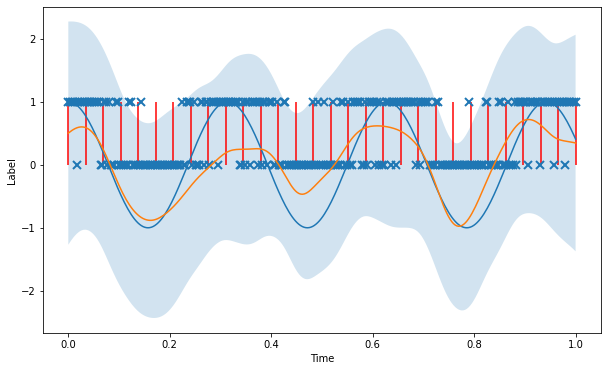

701 173.14080506829595


702 177.4280557721126


703 170.03197503597684


704 170.7029944454423


705 170.52708412318776


706 174.32794633124422


707 177.19110264982947


708 174.63418144250315


709 177.1192196269317


710 179.09462856781474


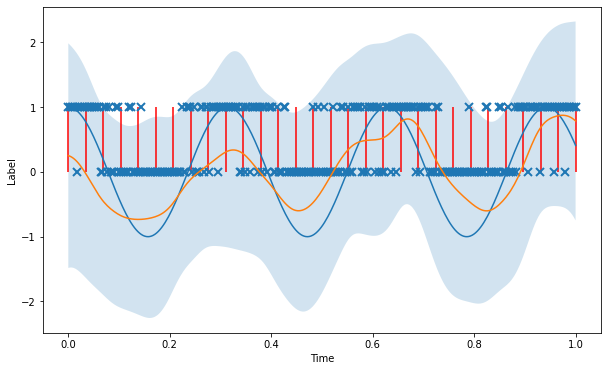

711 172.8436334252253


712 177.71281544410724


713 184.69269145401034


714 180.0443310474577


715 176.3399492672378


716 176.4585512540833


717 175.05524900821416


718 176.6859192918568


719 171.16734009722774


720 171.83129569913532


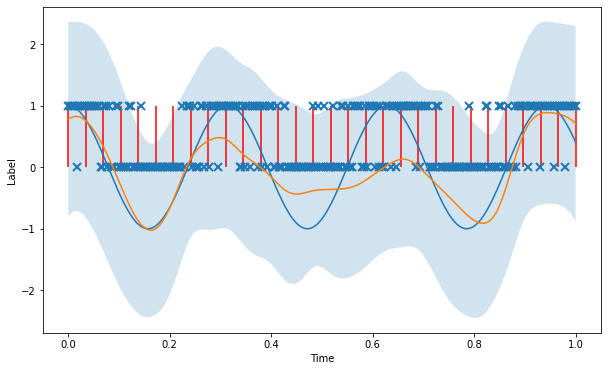

721 170.27164887391964


722 172.6228963989912


723 175.47084052025332


724 179.47605034410535


725 174.11638466763605


726 171.07150534158268


727 176.60777615801405


728 174.26863416792446


729 171.85899141584727


730 167.68818511258735


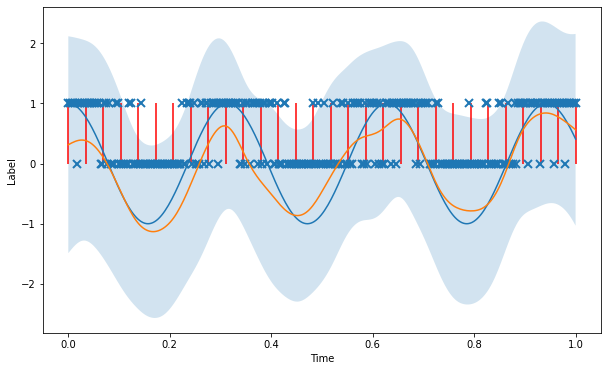

731 171.53806223598238


732 171.65618972207753


733 169.30618206350107


734 166.87154408720238


735 167.78558144413148


736 167.9195691839476


737 169.148584752528


738 173.2197862525723


739 181.19451566381946


740 172.14207359066592


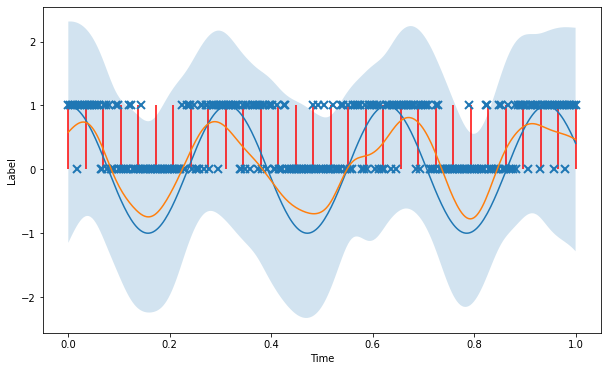

741 168.05594360554636


742 165.77565017758397


743 173.25895389980073


744 171.9649593041016


745 169.98130732809312


746 175.23954740138362


747 172.4026811061433


748 173.94152149281257


749 174.41239430636256


750 180.51750653667722


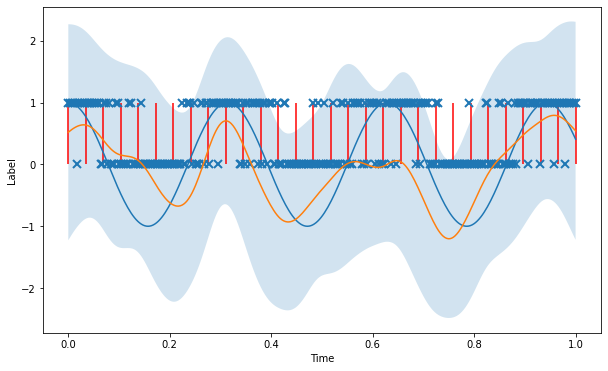

751 179.69403165474174


752 172.76604860634419


753 174.74409428836387


754 173.54953714012296


755 171.99968093412184


756 174.82522912973877


757 169.7749402418611


758 171.92661130251616


759 176.9064734091672


760 177.25399206101162


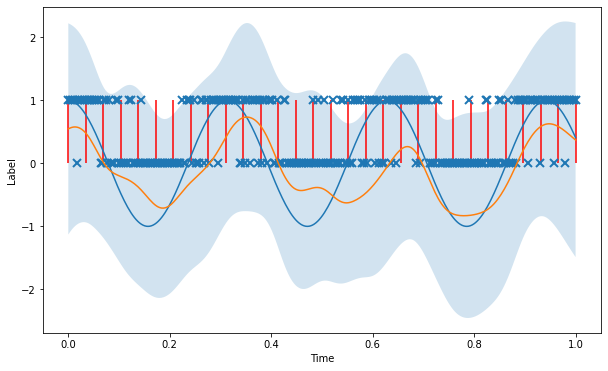

761 180.7677870349392


762 176.3790099767229


763 170.99845680251633


764 173.0418753458119


765 176.56299833890392


766 175.31471981251846


767 174.80824270487344


768 181.333285881506


769 177.38383281863113


770 179.55121481412684


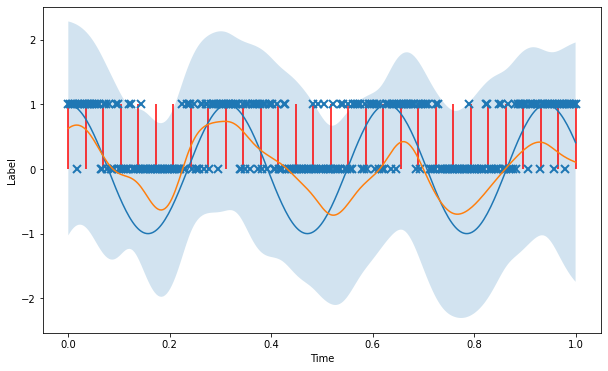

771 182.28429917041592


772 181.29086189093664


773 171.4317034802785


774 171.55807721322165


775 174.5605256351893


776 173.46240747111335


777 179.9834518023348


778 176.36062683878393


779 171.81319345200697


780 168.12025941480104


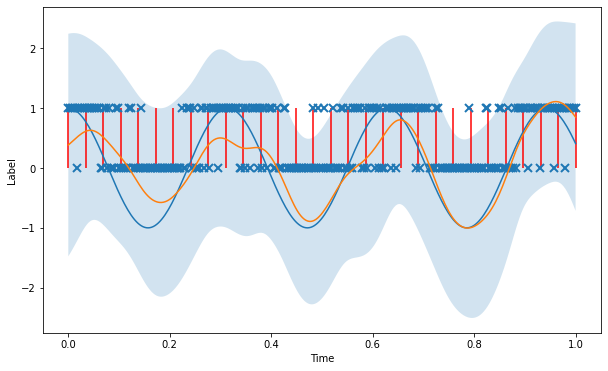

781 167.01760177478045


782 166.15982770765856


783 166.17041684179367


784 166.88346398431148


785 170.15774446437587


786 173.02126562205405


787 175.36360684514614


788 174.74936971846225


789 175.7222315454211


790 170.69870395597107


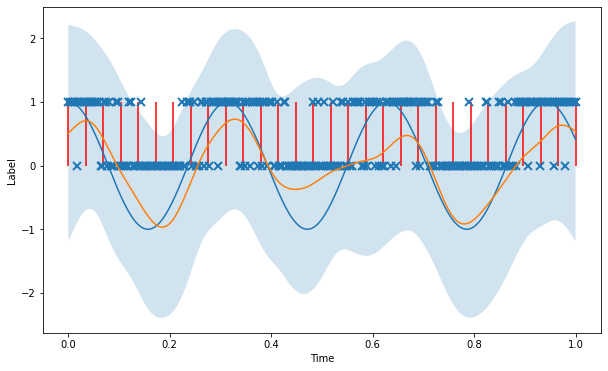

791 179.6723462784471


792 171.8872536449404


793 184.09392809598586


794 174.3059819196776


795 172.5739697064255


796 173.81742546747097


797 174.83245133820037


798 178.52851984228167


799 181.22417589106178


800 176.23705845207525


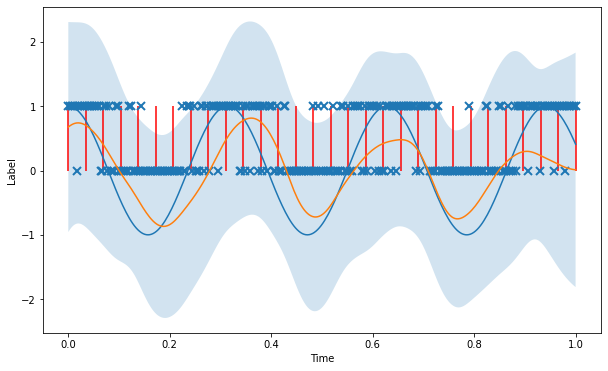

801 171.94685659700343


802 178.28136813823676


803 169.46318709679443


804 169.95737437605408


805 178.7626841797967


806 179.61616657107703


807 172.43592400332014


808 170.87130075778003


809 168.59085113103563


810 183.05178936916744


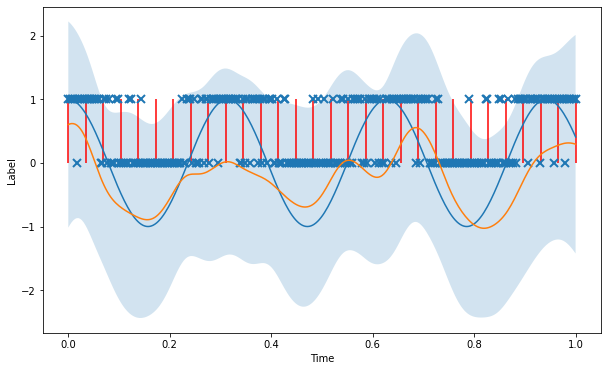

811 174.3186109113862


812 170.5430955073703


813 171.35447901314092


814 172.49007751383098


815 169.6776703604935


816 166.9699794363402


817 165.4337647999277


818 168.070927407806


819 174.39587259848042


820 176.30761277432404


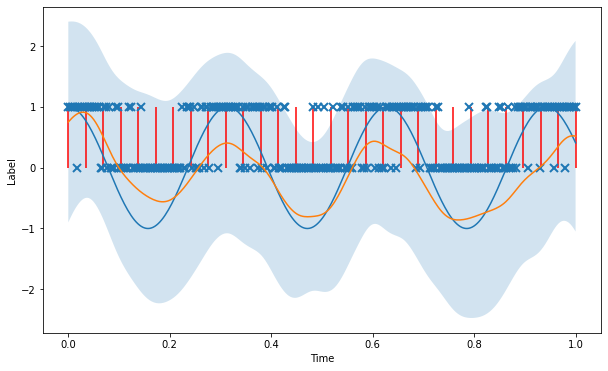

821 173.86477463009467


822 169.5556681886801


823 170.24165383947937


824 171.45216498883485


825 174.0241721094758


826 172.96810791241626


827 179.23373405945375


828 172.78647786400833


829 180.9714553249594


830 175.08125481546946


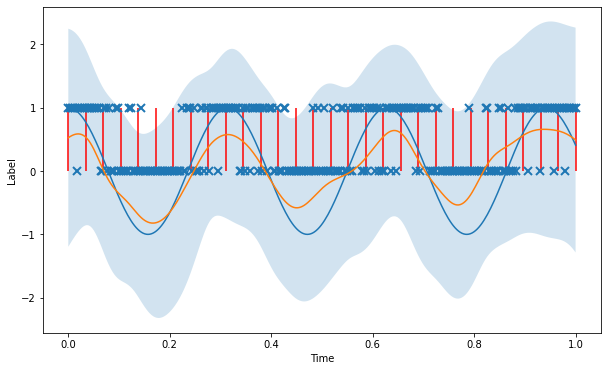

831 171.78824227846175


832 167.74933138945684


833 171.32228472469524


834 178.31253967698063


835 174.20609426222012


836 173.10758627603073


837 170.76866478757117


838 169.19985101838827


839 171.15367741403801


840 176.6499401310562


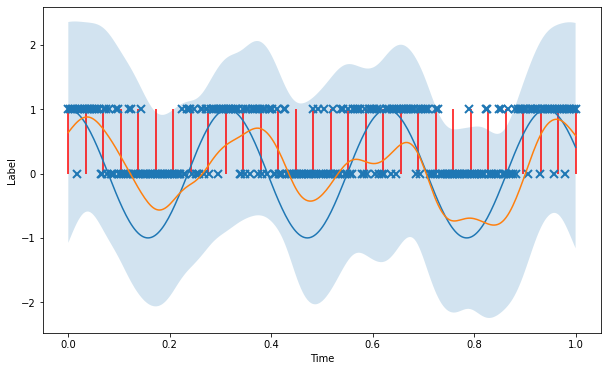

841 173.35390280102044


842 176.44906860132338


843 171.93344996523976


844 168.96254866210975


845 170.57914707207985


846 172.00098958020754


847 170.10273564848148


848 173.8241988011002


849 171.3816934565247


850 172.5265787442868


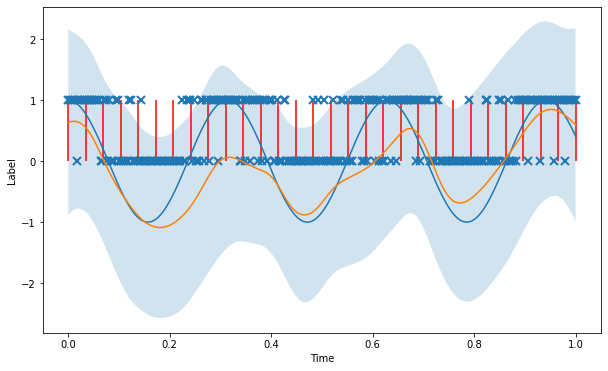

851 177.05755261749627


852 171.5361280975788


853 169.74524514970958


854 168.9877576366669


855 174.40262631405497


856 175.37984795148495


857 172.6796153508756


858 178.37471467195851


859 172.94330889537318


860 176.76596468682052


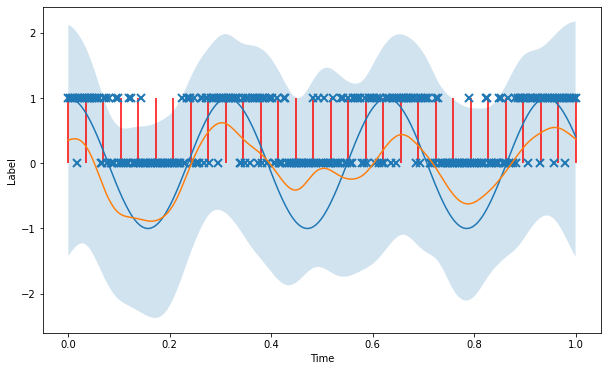

861 174.56393149453464


862 169.70142266001977


863 167.28490095429595


864 179.6811141499327


865 179.00363911190848


866 173.44281661351008


867 176.77010206011855


868 171.5062162728392


869 170.715941156147


870 171.76707637034158


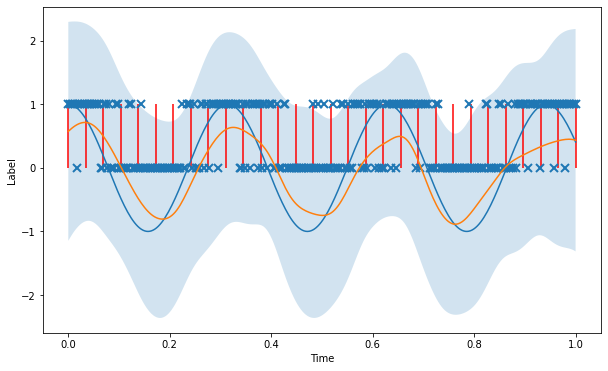

871 174.45331072177765


872 179.07160912168837


873 180.0550277949753


874 180.26234556878677


875 178.54299010021586


876 175.76732947458174


877 170.99673717788946


878 174.30582492271228


879 175.05711306046587


880 178.75556809978963


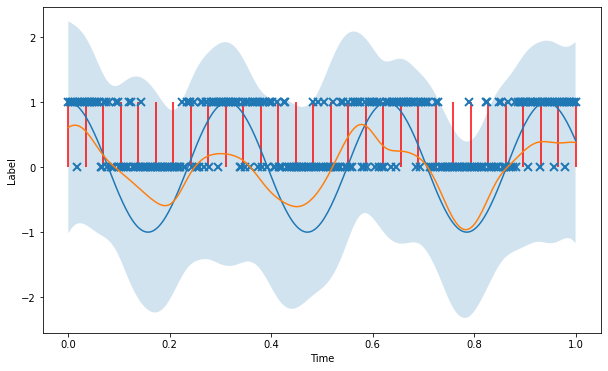

881 180.57053452847768


882 173.54150460072208


883 169.5153742694969


884 168.6055897555757


885 172.41024989578793


886 175.58934171252534


887 180.21240159968733


888 171.24604192720022


889 175.73596374543365


890 172.03373207759634


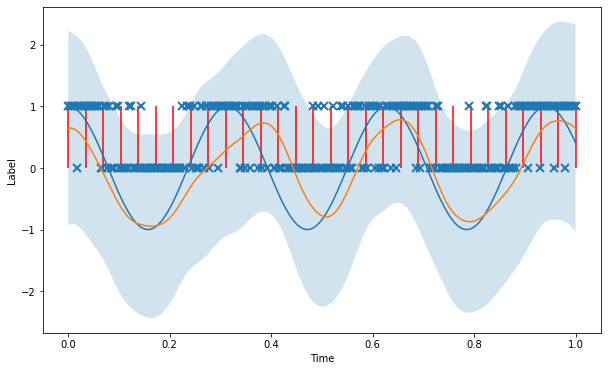

891 170.42784534214405


892 173.1961487102632


893 172.15248143224522


894 172.3139580046616


895 170.59926426585926


896 175.00307674130534


897 171.86210884883388


898 180.40972239520494


899 173.13973217921298


900 173.64357322022693


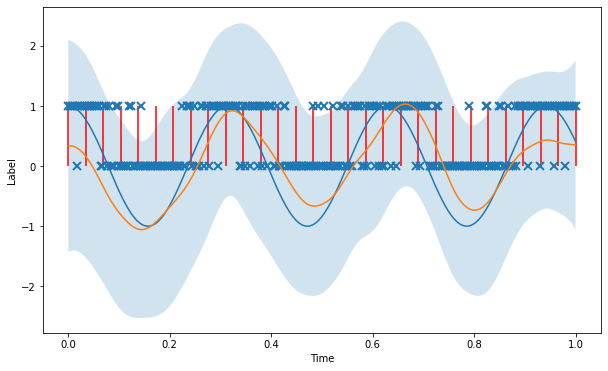

901 177.61053191870718


902 176.65095413332233


903 177.1563841829707


904 176.65485070658946


905 174.37091671943438


906 172.34540174832028


907 176.79366749958513


908 182.7293660714511


909 176.05267179726602


910 179.33766109483116


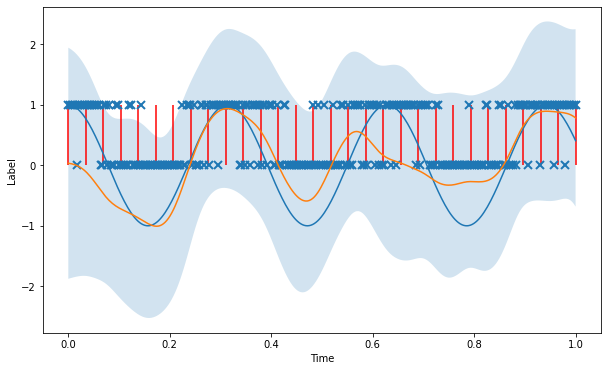

911 171.68167226395008


912 173.9977905562701


913 171.24895465485966


914 174.61742899129626


915 170.957572141659


916 167.62903618200914


917 169.02045815763606


918 171.42595828045043


919 175.5288357060885


920 174.71800364202232


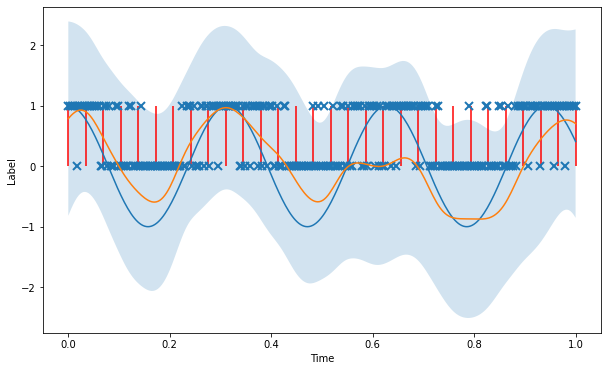

921 169.57333587514412


922 173.85709887081256


923 174.210802708883


924 175.40974471613063


925 171.6806085027669


926 170.00356245027274


927 170.43680943752992


928 173.84614351928352


929 174.15467100570726


930 171.3494462253256


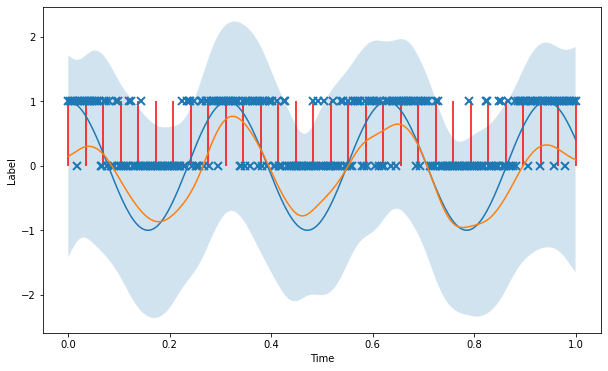

931 168.97055434391288


932 166.72669075251196


933 168.68394746262524


934 179.68305636120962


935 177.40529676123884


936 174.97620384618176


937 175.27303570166245


938 170.935016170074


939 171.38909697229613


940 174.4442167896859


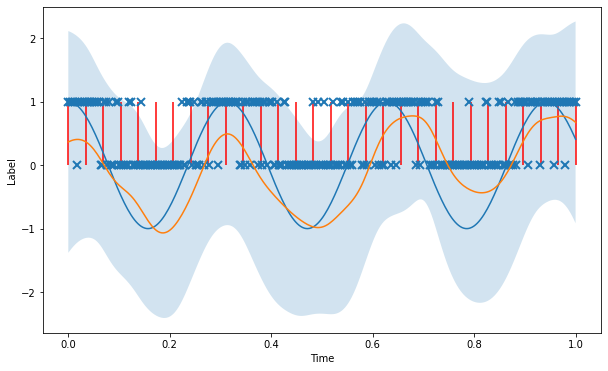

941 172.8318099193941


942 175.6540581920396


943 175.16909116356115


944 169.18921820289785


945 174.7803654887543


946 180.1766832760085


947 184.101066629517


948 176.85365407036667


949 173.11077837688083


950 174.54841937349582


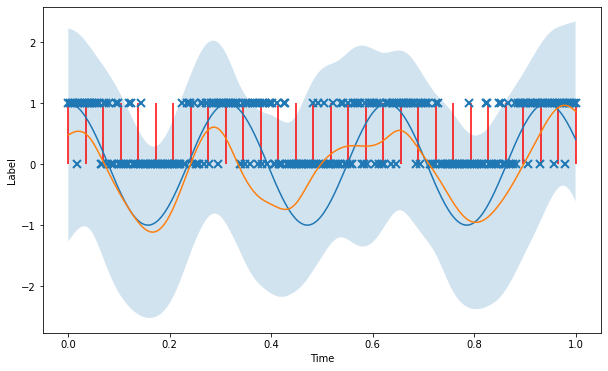

951 173.61301697188642


952 171.4765210067604


953 171.28682389607678


954 176.1199129198574


955 171.97488389385526


956 173.3103665504379


957 181.05742241694242


958 180.0170858355723


959 177.25544853889505


960 172.15251520991436


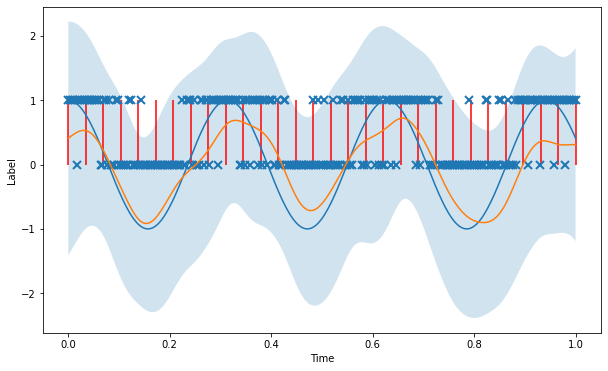

961 182.83672017491813


962 175.310790755086


963 173.2788914077421


964 170.42604647250636


965 172.09378811528498


966 175.20142759116132


967 174.0036063813891


968 170.92279297329296


969 169.94253122352495


970 170.59407825880032


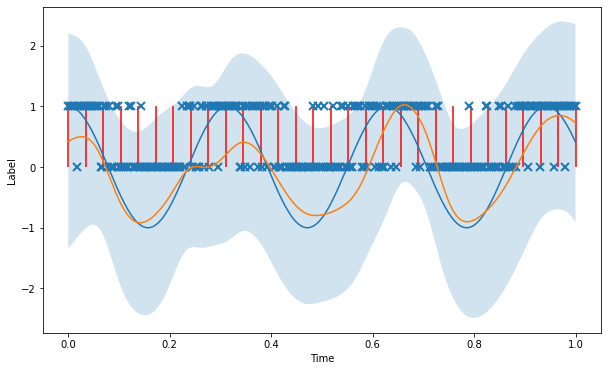

971 170.0507212816743


972 166.86214187480095


973 168.2108606829353


974 171.98534699521113


975 175.75306370224214


976 173.93891876814138


977 175.7788524861783


978 170.76475635056283


979 170.85443871345961


980 174.42107512360417


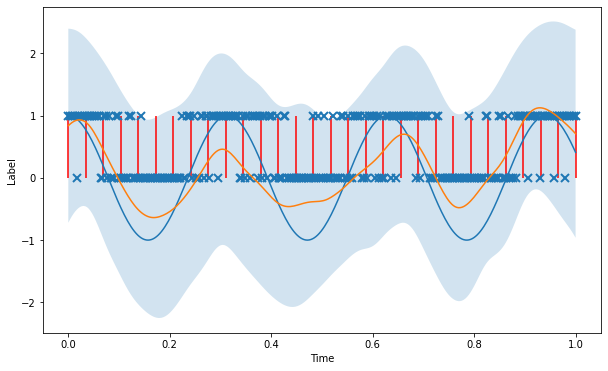

981 176.4336597634155


982 171.8062781265245


983 171.04165458246703


984 178.97444631785487


985 173.16948699946056


986 174.75768836005295


987 177.20078517888885


988 175.7535891598408


989 172.50036930776426


990 170.84353497498373


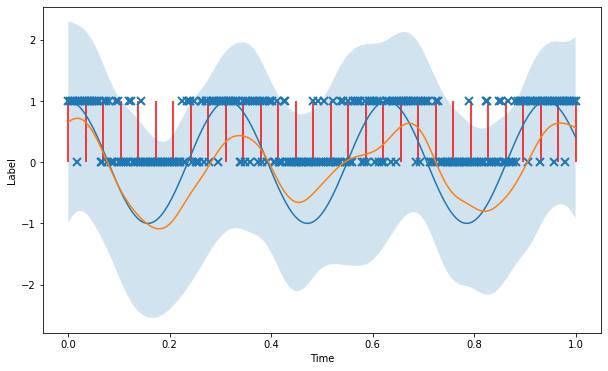

991 175.4281144641113


992 171.9159302421051


993 171.3433718109263


994 170.91045059630483


995 174.5786224427292


996 176.27675277895406


997 175.16816151505844


998 170.10193678611355


999 174.29605689177401


In [4]:
# Create a likelihood object
variance = 1.
alpha = 1.
base_likelihood = Bernoulli()
likelihood = PEPScalarLikelihood(base=base_likelihood)
spep = SparsePowerExpectationPropagation(kernel=kernel,
                                         inducing_points=tf.constant(inducing_points),
                                         likelihood=likelihood,
                                         learning_rate=.5,
                                         alpha=alpha)


def plot_model(model):

    f_mu, f_var = model.posterior().predict_f(time_points)
    f_mu = f_mu.numpy()
    f_std = np.sqrt(f_var)

    plt.figure(figsize=(10, 6))
    plt.vlines(inducing_points, ymin=observations.min(), ymax=observations.max(), color='r')
    plt.plot(time_points, observations, 'C0x', ms=8, mew=2)
    plt.plot(time_points, F, 'C0', ms=8, mew=2)
    plt.plot(time_points, f_mu, 'C1', ms=8, mew=2)
    plt.fill_between(
        time_points,
        y1 = (f_mu - 2 * f_std).reshape(-1,),
        y2 = (f_mu + 2 * f_std).reshape(-1,),
        alpha=.2
    )
    plt.xlabel("Time")
    plt.ylabel("Label")
    plt.show()


trainable_vars = (spep._kernel.trainable_variables) \

opt_adam = tf.optimizers.Adam(0.01)

#@tf.function
def adam_step():
    opt_adam.minimize(lambda: -spep.energy(data), trainable_vars)

#@tf.function
def natgrad_step(input_data):
    spep.update_sites(input_data)

plot_model(spep)


input_data = (time_points, observations)

batch_size = num_data // 10
max_iter = ci_niter(1000)
for rep in range(max_iter):
    time_points, observations = input_data

    indices = np.random.permutation(num_data)[:batch_size]
    sub_input_data = (time_points[indices], observations[indices])

    natgrad_step(sub_input_data)
    #adam_step()
    print(rep, -spep.energy(input_data).numpy())

    if rep % 10 == 0:
        plot_model(spep)